# Drug Response Prediction (DRP) using phosphoproteomics data

## Problem Formulation 

The goal of DRP is to predict how effective different drugs are for different cancer types. 
Here we predict the I50 values, the concentration of a drug needed to inhibit the activity of a cell lie by 50%, as a measure of efficacy. 
We feed phosphoproteomics profiles of cell lines and simple column representaions of drugs though a neural network to do this. 

Consider the traning set $T = \{ \boldsymbol{x_{c,i}}, \boldsymbol{x_{d,i}}, y_i\}$ where 
$\boldsymbol{x_{c,i}}$, $\boldsymbol{x_{d,i}}$  are representation of the $i^{th}$ cell line and drug respectively and
 $y_i$ is the IC50 value associated with the $i^{th}$ cell line drug pair.

 Thus, we want to find a model, $M$, that takes $\boldsymbol{x_{c,i}}$ and $\boldsymbol{x_{d,i}}$ as inputs and predicts for the corresponding IC50 value $\hat{y_i}$ such that $M(\boldsymbol{x_{c,i}}, \boldsymbol{x_{d,i}})=\hat{y_i}$.

We test the model on what is known as cell blind testing. This means that none of the cell lines in the testing set are in the training set. Cell blind testing simulates how a model would perform in a stratified medicine context. Where previous patents' responses to a set of drugs would be available for training and the goal would be to predict the response of a new patent to these drugs. 

In [72]:
import torch
import sys
import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
sys.path.append('..')
from src import create_dataset, utils, models, traning, eval_model
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [76]:
reload(models)
reload(utils)

<module 'src.utils' from 'c:\\Users\\Nik\\Documents\\PhD_code\\year2_code\\Phos_drp_example\\notebooks\\..\\src\\utils.py'>

## Data preprocessing 

Here we load in our input and truth value data. 

The input omics data is phosphoproteomics profiles of cancer cell lines. 

The input drug data is marker drug representations, these are unique one-hot encoded column vectors that do not contain any chemical properties.

The  truth values describes how effective different drugs are at killing cell lines. Here we are using IC50 values for this.

The IC50 values are from the GDSC1 database https://www.cancerrxgene.org/

The omics data is from the  paper Drug ranking using machine learning systematically predicts the efficacy of anti-cancer drugs https://www.nature.com/articles/s41467-021-22170-8

In [4]:
data = create_dataset.DrpInputData(omic_types=['phos'])
#Keps only cell lines that have truth value and omics profiles
data.remove_disjoint()

In [17]:
data.phos

col.name,KDM1A(S45);,KDM1A(T19);,ZFP91(S69);,INCENP(T150);,INCENP(T153);,INCENP(T153);INCENP(T135);,INCENP(M136);INCENP(T145);INCENP(S148);,EIF3J(S11);EIF3J(S13);,POLE4(S9);,SAMD1(T157);,...,CTDP1(T340);,EPS8L2(T572);,BEGAIN(S455);,HNRNPL(S52);,GMDS(T327);,BOD1L1(S482);BOD1L1(S484);,ARHGEF35(T193);,ARHGEF5(S184);,PSMB2(T148);,HSP90AA1(S476);
CMK,-9.751659,-9.751659,6.298313,3.897353,6.801432,6.270551,0.925999,2.077243,-9.751659,8.603255,...,-9.751659,-8.751659,4.683472,4.285402,-9.751659,-0.388355,-9.751659,-9.751659,0.575312,1.627607
COLO-680N,-9.158429,-9.158429,4.479295,5.005041,6.620465,5.830401,0.765535,0.487229,-0.349235,7.013462,...,-9.158429,7.549977,5.488547,4.649615,-9.158429,-9.158429,0.214125,1.263034,-2.403542,3.378512
GDM-1,-9.522178,-9.522178,2.807355,4.263786,6.313452,5.388925,0.356144,1.062812,3.184280,8.247928,...,-9.522178,-8.522178,7.215484,4.935460,-0.954557,-0.948976,-9.522178,-9.522178,1.952334,3.320485
HEL,-11.117787,0.641546,3.539779,3.805292,6.411765,5.724105,-11.117787,1.891419,-11.117787,8.733354,...,-11.117787,0.333939,3.135535,4.209453,-1.577767,-11.117787,-11.117787,-11.117787,0.389567,3.279471
HL-60,-11.200250,-11.200250,5.420314,3.594549,4.385697,4.070426,-11.200250,4.852998,-11.200250,5.044394,...,3.584963,-10.200250,7.209458,4.678072,-11.200250,-11.200250,-11.200250,-11.200250,-2.011588,2.536053
JHH-2,-10.000831,-10.000831,2.356419,2.653284,4.659352,3.273661,-10.000831,-9.000831,-10.000831,6.195348,...,-10.000831,7.845490,5.852249,2.985500,4.270529,-10.000831,4.153805,3.292782,-10.000831,2.545968
JHH-4,1.790772,-9.532825,4.705917,4.863014,6.920043,6.361926,1.773996,0.743300,-9.532825,6.137504,...,-9.532825,5.529509,6.375853,3.877744,1.713696,-9.532825,2.839960,0.773996,-9.532825,3.336283
KASUMI-1,-10.480357,-10.480357,5.850999,3.267641,5.040923,4.307480,-10.480357,1.989139,-10.480357,8.485829,...,2.427606,1.914832,-1.416192,2.998196,-10.480357,2.292782,-10.480357,-10.480357,-10.480357,-10.480357
KG-1,-10.582840,-10.582840,6.659542,1.531395,4.475776,3.744231,-10.582840,2.742006,-10.582840,7.156842,...,-10.582840,-1.130833,6.456160,3.523562,4.201634,0.137504,-10.582840,-10.582840,2.223423,2.223423
KMOE-2,4.572890,1.778209,5.472455,3.517276,5.602310,4.672462,-10.602894,3.121015,0.871844,7.660353,...,0.887525,1.541338,4.222650,3.459432,-10.602894,-10.602894,-10.602894,-10.602894,-10.602894,2.639232


In [18]:
data.y_df

DRUG_NAME,(5Z)-7-Oxozeaenol,5-Fluorouracil,A-443654,A-770041,A-83-01,ACY-1215,AGI-6780,AICA Ribonucleotide,AKT inhibitor VIII,AR-42,...,YK-4-279,YM201636,Z-LLNle-CHO,ZG-10,ZM447439,ZSTK474,Zibotentan,"eEF2K Inhibitor, A-484954",kb NB 142-70,rTRAIL
CMK,0.533605,1.356067,-1.225855,3.423778,4.279684,0.445262,0.883803,7.306995,1.628922,-2.703728,...,0.711090,1.010783,-0.168536,NaN,2.327991,-1.569145,4.348476,4.607164,1.816375,-0.475125
COLO-680N,1.729743,5.825205,NaN,NaN,2.311197,1.541306,1.857318,7.779938,3.089514,4.383391,...,2.914492,4.505976,NaN,NaN,2.786317,2.637072,5.998495,6.098361,2.709776,0.660982
GDM-1,-0.523250,0.919553,-0.689946,3.007763,3.101210,0.299259,1.086986,6.873515,0.480957,-2.204147,...,1.159891,0.016884,0.785866,NaN,3.944803,-2.732485,4.779900,4.951323,1.217470,-1.530039
HEL,0.948509,0.096313,-0.847805,2.509067,4.442955,0.781370,1.223233,6.679720,2.108089,-2.640470,...,1.243856,1.034155,-0.259764,NaN,1.877772,0.437604,4.329365,4.893941,2.141834,-2.435046
HL-60,1.426720,1.847379,0.275800,2.246344,4.317315,0.584272,0.977314,5.779418,2.343589,-2.105449,...,1.936856,2.055140,0.738669,NaN,0.933645,-0.935734,5.244023,5.293992,1.350463,-0.662189
JHH-2,1.250863,2.805717,NaN,NaN,4.809860,1.352882,1.928683,8.068791,3.800954,-0.538916,...,1.615375,3.477278,NaN,NaN,3.867514,2.235465,5.593274,5.498093,1.677161,-0.590448
JHH-4,1.728183,3.831835,NaN,NaN,3.052734,1.682833,1.190176,8.236501,0.179473,-1.997605,...,0.555819,1.577455,NaN,NaN,2.356895,0.038652,5.468000,5.148859,2.785413,-4.329280
KASUMI-1,-1.027736,NaN,1.660142,3.912199,NaN,NaN,NaN,5.942764,-0.691354,NaN,...,1.010631,NaN,1.495208,NaN,NaN,-3.322155,NaN,NaN,NaN,-1.806383
KG-1,-0.741724,3.220940,1.197924,3.882495,2.205678,0.880823,1.062529,5.729228,2.041374,-2.120892,...,0.388608,0.935345,1.712625,NaN,1.642640,0.480226,5.296632,4.591654,1.126185,-0.319311
KMOE-2,-1.408182,1.864702,-0.767405,3.672939,4.940030,0.952982,0.825652,5.761281,1.074860,-2.008743,...,-0.063605,0.156328,0.065058,NaN,1.380753,0.057000,5.551606,5.178670,2.245417,-0.429986



The above shows the phos data has 42 rows and 22804 columns. Thus, it gives the expression values for 42 cell lines for 22804 phosphopeptide. 

The y data gives the IC50 values for the 42 cell lines in the phos treated with 345 different drugs 

The input we want for drug response prediction is drug cell line pairs because we want to predict the efficacy of a given drug for a given cell. Therefore, the next step is to use the df we have to create inputs for all drug cell line pairs.


In [9]:
#data for all drugs
x_all_phos, x_drug, y_list = utils.create_all_drugs(
    data.phos, data.marker_drugs, data.y_df)

x_all_phos = x_all_phos.astype(np.float32)
x_drug = x_drug.astype(np.float32)
y_list = y_list.astype(np.float32)
pairs_with_truth_vals = y_list.index

In [10]:
x_all_phos

col.name,KDM1A(S45);,KDM1A(T19);,ZFP91(S69);,INCENP(T150);,INCENP(T153);,INCENP(T153);INCENP(T135);,INCENP(M136);INCENP(T145);INCENP(S148);,EIF3J(S11);EIF3J(S13);,POLE4(S9);,SAMD1(T157);,...,CTDP1(T340);,EPS8L2(T572);,BEGAIN(S455);,HNRNPL(S52);,GMDS(T327);,BOD1L1(S482);BOD1L1(S484);,ARHGEF35(T193);,ARHGEF5(S184);,PSMB2(T148);,HSP90AA1(S476);
CMK::(5Z)-7-Oxozeaenol,-9.751659,-9.751659,6.298313,3.897353,6.801432,6.270551,0.925999,2.077243,-9.751659,8.603255,...,-9.751659,-8.751659,4.683472,4.285402,-9.751659,-0.388355,-9.751659,-9.751659,0.575312,1.627607
COLO-680N::(5Z)-7-Oxozeaenol,-9.158429,-9.158429,4.479295,5.005041,6.620465,5.830401,0.765535,0.487229,-0.349235,7.013462,...,-9.158429,7.549977,5.488547,4.649615,-9.158429,-9.158429,0.214125,1.263034,-2.403542,3.378512
GDM-1::(5Z)-7-Oxozeaenol,-9.522178,-9.522178,2.807355,4.263786,6.313452,5.388925,0.356144,1.062812,3.184280,8.247928,...,-9.522178,-8.522178,7.215485,4.935460,-0.954557,-0.948976,-9.522178,-9.522178,1.952334,3.320485
HEL::(5Z)-7-Oxozeaenol,-11.117787,0.641546,3.539779,3.805292,6.411765,5.724104,-11.117787,1.891419,-11.117787,8.733355,...,-11.117787,0.333939,3.135535,4.209454,-1.577767,-11.117787,-11.117787,-11.117787,0.389567,3.279471
HL-60::(5Z)-7-Oxozeaenol,-11.200250,-11.200250,5.420314,3.594548,4.385697,4.070426,-11.200250,4.852998,-11.200250,5.044394,...,3.584963,-10.200250,7.209457,4.678072,-11.200250,-11.200250,-11.200250,-11.200250,-2.011588,2.536053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNU-387::rTRAIL,-9.142035,-9.142035,3.607153,4.711592,5.925401,4.632371,-9.142035,-8.142035,-9.142035,6.383704,...,-9.142035,4.783980,6.199476,2.046142,3.837943,-9.142035,1.007195,-9.142035,-9.142035,3.632268
SNU-398::rTRAIL,2.403268,1.713696,0.380585,4.009156,5.612441,4.875288,-9.062746,-8.062746,3.963474,8.393176,...,-9.062746,6.139551,-8.062746,4.145678,-9.062746,-9.062746,0.863938,-9.062746,1.070389,2.653060
SNU-423::rTRAIL,1.769772,0.790772,5.873050,4.087645,5.582560,4.832998,-1.123434,-7.868174,2.295723,8.499846,...,-8.868174,8.450386,0.772308,4.017922,0.782409,-8.868174,4.217231,-8.868174,-8.868174,3.733354
SNU-449::rTRAIL,-10.361713,-10.361713,-0.144010,5.004951,5.659725,4.160275,-10.361713,-9.361713,-10.361713,6.797013,...,-10.361713,7.923625,6.591290,3.572890,4.385431,-10.361713,1.744161,-10.361713,-10.361713,4.472488


## Train test split

In [88]:
_all_cls = data.phos.index
_all_drugs = data.all_drugs
train_size=0.8
rand_seed=42

train_pairs, test_pairs = utils.split(
    rand_seed, _all_cls, _all_drugs, pairs_with_truth_vals,
    train_size=train_size, split_type='cblind')

print('------')
print('split test into a test and val set')

test_cls = np.unique([cl.split('::')[0] for cl in test_pairs])
val_pairs, test_pairs = utils.split(
    rand_seed, pd.Index(test_cls), _all_drugs, test_pairs,
    train_size=0.5, split_type='cblind')    

xo_train_phos = x_all_phos.loc[train_pairs]
xo_val_phos = x_all_phos.loc[val_pairs]
xo_test_phos = x_all_phos.loc[test_pairs]

xd_train = x_drug.loc[train_pairs]
xd_val = x_drug.loc[val_pairs]
xd_test = x_drug.loc[test_pairs]


y_train = y_list[train_pairs]
y_val = y_list[val_pairs]
y_test = y_list[test_pairs]

Fraction of cls in sets, relative to all clsbefore mising values are removed
train fraction 0.7857142857142857, test fraction 0.21428571428571427
------
Fraction of cls in sets, relative to all cl drug pairs, after mising values are removed
train fraction 0.6897860593512768, test fraction 0.20069013112491374
------
split test into a test and val set
Fraction of cls in sets, relative to all clsbefore mising values are removed
train fraction 0.4444444444444444, test fraction 0.5555555555555556
------
Fraction of cls in sets, relative to all cl drug pairs, after mising values are removed
train fraction 0.40933977455716586, test fraction 0.5272141706924316


In [89]:
train_dls = utils.into_dls([np.expand_dims(xo_train_phos.values, 1),
                            xd_train.values, 
                            np.expand_dims(y_train, 1)])

val_dls = utils.into_dls([np.expand_dims(xo_val_phos.values, 1), 
                          xd_val.values, 
                          np.expand_dims(y_val, 1)])

test_dls = utils.into_dls([np.expand_dims(xo_test_phos.values, 1), 
                           xd_test.values, 
                           np.expand_dims(y_test, 1)])

## Model traning

In [ ]:
hps = {'out_channels': 32, 
'lr': 0.0001, #try 
'linear_neurons2': 96, 
'linear_neurons': 256, 
'drop_p': 0}
adphos = models.CnnDualInputs(hps).to(device)
hist = traning.tl_multi_dls(
    train_dls=train_dls[: 2],
    y_train=train_dls[-1],
    val_dls=val_dls[: 2],
    model=adphos,
    optimiser=torch.optim.RMSprop(adphos.parameters(), lr=hps['lr']), 
    epochs=300,
    y_val=val_dls[-1],
    early_stopping_dict={'patience': 50, 'delta': 0.0}
    )

MinMetric(mean=1.6572637955347698, sd=0.0, index=233)


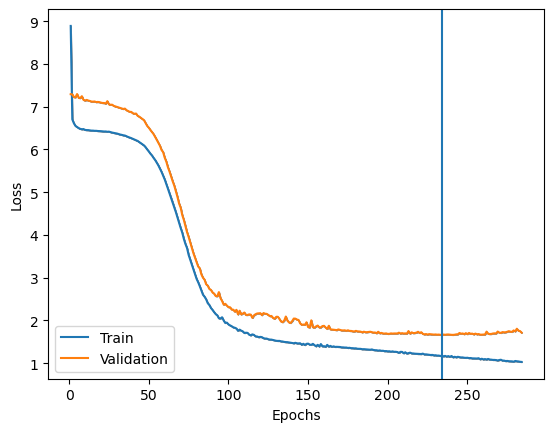

In [102]:
utils.plot_cv(hist['train_loss'], hist['val_loss'], epochs=284)

In [103]:
eval_model.find_metrics(eval_model.eval_torch(test_dls, adphos), y_test)

{'PCC': 0.8780390615425068,
 'Rho': 0.8646611982749217,
 'MSE': 1.5358647,
 'R2': 0.7480946114745343}